# Cross Validation
Anytime we are building predictive models we need to consider a number of things, and chiefly
among these is how we train the model when using the `fit()` function. This function does all the heavy
lifting for us, and will use all of the data we give it to try and learn the best model it can. This
can lead to overfitting, where the model created works really well on the data it was given, but
doesn't generalize well to new data. Now, we've already seen two tactics: first, we separate our data
into a train/test set, this gives us a realistic understanding of how well our model will perform on
new data, and second, we can change model parameters like `C` to penalize overfitting.

But really how big should your
train/test split be? A more common approach in modern machine learning is to not have a strict split
of your data, but instead to have many different splits of your data and train many models, to get a
better estimate of how well the model might work. This is called cross validation, and sklearn has
support build right into the `model_selection` module.

In [1]:
# Let's bring in our imports and baseball data as we did before
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile

filename="assets/baseball_svm_data.zip"
df=pd.read_csv(zipfile.ZipFile(filename).open("reg_Sep2019.csv"))
df.head()

,pitch_type,release_speed,release_pos_x,release_pos_z,player_name,batter,events,description,zone,des,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,FS,81.2,-1.0920,6.3157,Jake Faria,435622,run,ball,13.0,Wild pitch by pitcher Jake Faria. Sam Hillia...,...,3,3,3,3,3,3,3,3,Strategic,Strategic
1,FF,90.0,-0.8826,6.4818,Jake Faria,435622,NaN,called_strike,5.0,NaN,...,3,3,3,3,3,3,3,3,Strategic,Strategic
2,SL,83.8,-0.9456,6.2833,Jake Faria,602074,single,hit_into_play_no_out,2.0,Yonathan Daza singles on a bunt ground ball to...,...,3,3,3,3,3,3,3,3,Standard,Standard
3,FF,92.3,-0.8358,6.3745,Jake Faria,602074,NaN,foul,5.0,NaN,...,3,3,3,3,3,3,3,3,Standard,Standard
4,FF,93.0,-0.7746,6.4466,Jake Faria,656541,walk,ball,11.0,Sam Hilliard walks.,...,3,3,3,3,3,3,3,3,Infield shift,Standard


In [3]:
# Sincer we're old hats at this now, I'm going to add in a bit more data. Let's move from a binary
# prediction into a multiclass prediction. Specifically, it seems we can differentiated from two
# kinds of pitches, let's add in a few more. Here's a list of all of the different pitches and the
# number of them in our datafile.
df.groupby("pitch_type").apply(lambda z: f"{z['pitch_name'].unique()[0]} {len(z)}")

pitch_type
CH            Changeup 4485
CU           Curveball 4141
EP                 Eephus 3
FC              Cutter 2309
FF    4-Seam Fastball 14039
FS         Split Finger 575
FT     2-Seam Fastball 3203
KC        Knuckle Curve 656
SI              Sinker 2924
SL              Slider 7656
dtype: object

In [4]:
# We can see there is a fair bit of diversity here, but we have significant class imbalance. Turns
# out very few pitches just lob the ball out there with an Eephus pitch -- I know I've never seen
# one! But let's try and predict all of these different types, and lets use a host of different
# features. First up: pitching metrics
pitch_metrics=['release_spin_rate','release_extension','release_pos_y','release_pos_x','release_pos_z','effective_speed']

# I think we should add the pitcher name too, why not? It could be that some pitchers have favorites
player_metrics=['player_name']

# Pitchers might change their strategy when they already have outs, or when they are deep in the
# game.
game_details=['outs_when_up','inning']

# Take a minute and think about what you know about the game of baseball. What other features might
# be predictive of the next pitch a pitcher will throw?

In [6]:
# Now let's combine our features and reduce our DataFrame
df=df[[*pitch_metrics, *player_metrics, *game_details, "pitch_type"]]

# Now let's drop where any of the pitches are nan
df=df.dropna(subset=["pitch_type"])

# I also want to factorize on the player name, since we need numeric values for SVMs
df['player_name']=df['player_name'].factorize()[0]

# That should give us roughly 40,000 observances. Let's prune out roughly 35,000 for our validation set
df_validation=df[-35000:]
df_pitches=df[0:-35000]

features=[*pitch_metrics, *player_metrics, *game_details]

# Now let's impute data for the missing data in our training set. There are not many, so I'm just going
# to use a simple mean approach
df_pitches=df_pitches.fillna(df_pitches.mean(numeric_only=True))

In [7]:
# In a cross validation approach we break the original data into a number of equal subsets, called folds, 
# and then we hold one of those for testing and we train on the rest. We repeat this procedure for each fold. 
# Sometimes this is called k-fold cross validation, where k is the number of folds you use. And of course,
# sklearn has this built in for us
from sklearn.model_selection import cross_validate
from sklearn import svm

# Now we create the model we are interested in. Now, the linear SVM did well and it was nice and simple,
# but it turns out that the default implementation of the linear SVM in sklearn is pretty slow, and our
# data is getting up there in size. The fifth degree polynomial seemed to have the same accuracy and is
# and is roughly ten times faster on this data.
clf=svm.SVC(kernel='poly', degree=5, C=15, coef0=5, random_state=1337)

# Once we have this done, we simply give the model and the data to sklearn, tell it how many folds we want
# to perform - in this case I'll do just 5 folds - and then what metrics we want to use to evaluate how
# good the fit was. We're going to keep using accuracy here, but as you'll see in the future, that's not
# really ideal given that we have such high class imbalance
results=cross_validate(clf,df_pitches[features],df_pitches["pitch_type"],cv=5,scoring='accuracy')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Ok, while that's crunching away - and remember, this is almost 5,000 observations we are going to fit five times over, so it's going to take awhile - lets talk about what you actually use cross validation for. Cross validation does not improve your model. Your model is going to be trained on all of the training data you have when it comes to actually building your final model. Cross validation does not change the hyperparameters you are using either. Instead, cross validation gives you a stronger understanding of how generalizable your model will be to new data. Think of it this way, you might have created a great model on September's baseball data, which is the data we are using, but if it doesn't generalize to October they're going to laugh back in the office pool. You don't want that.

The cross validation in the notebook should be done by now, let's go check it out.

In [8]:
# The results of the corss_validate() function are a dictionary which has some timing information and
# our test scores, and it's this last one that we're most interested in
print(f"The cv score results are {results['test_score']}")

# And since we have now run many different models, we can get an overall average as well as a standard
# deviation, which is helpful in knowing how likely we are to get a model with a given accuracy.
print(f"The average cv score results are {np.mean(results['test_score'])} with a standard deviation of {np.std(results['test_score'])}")

The cv score results are [0.61961962 0.66933868 0.66132265 0.63226453 0.63326653]
The average cv score results are 0.6431624008778318 with a standard deviation of 0.018899451244109383


In [9]:
# Great, so how well does this model *actually* work on our validation data? Well, let's take a look!
# First, we need to independly impute the missing values
df_validation=df_validation.fillna(df_validation.mean(numeric_only=True))

# Now we can check this against our trained (fitted) classifier
clf.fit(df_pitches[features],df_pitches["pitch_type"])
clf.score(df_validation[features],df_validation["pitch_type"])

0.5673428571428571

Ok, that's an overview of how we can apply support vector machines to pitch data from the MLB. Now, our accuracy at the end didn't seem like it was very good - only 57%. But we are predicting across many different classes of pitches, and it's not really clear where our model goes wrong. Does it mispredict one class completely? Or is it equally bad at all of the classes? The answer is, I don't know, but I know how to find out, and in the next lecture we're going to look at a different dataset where this comes up, and I'll show you the techniques data scientists use to understand their model performance better.

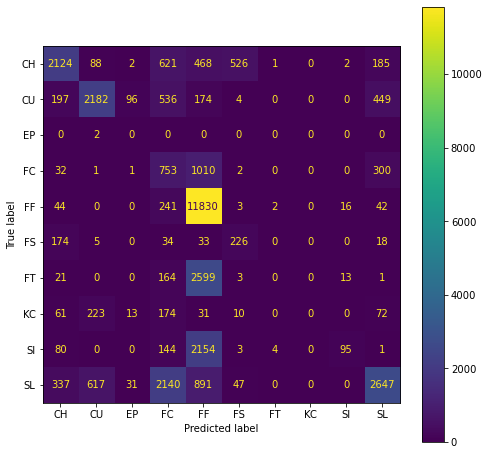

In [11]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix=ConfusionMatrixDisplay.from_estimator(clf, df_validation[features], df_validation['pitch_type'])
matrix.figure_.set_size_inches(8,8)